In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os.path
from datetime import date
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from category_encoders.target_encoder import TargetEncoder 
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
sns.set(style="darkgrid") # darkgrid

class DataProcessor:
    def __init__(self) -> None:
        pass 
    def processing(
            self,
            df:pd.DataFrame,
            target_col:str,
            standarization:bool=False,
            filling_method:list=None,
            drop_cols:list=None,
            encoding:str=None,
            split_data:bool=None,
            random_state:int=None):
        # filling
        # encoding 
        # standarization
        df.drop(drop_cols, axis=1, inplace=True) 
        numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
        if filling_method:
            # assert() at most 2 method
            numeric = 'default'
            category = 'default'
            for m in filling_method:
                kind, method = m.split(':')
                if kind == 'numeric':
                    numeric = method
                elif kind == 'category':
                    category = method
                else:
                    print('kind error')
            df = self.filling(df, target_col, numeric_cols, numeric_method=numeric, categorical_method=category)
        
        if encoding:
            df = self.encoding(df, target_col, encoding, numeric_cols)

        if standarization:
            df = self.standarization(df, numeric_cols)
        
        if split_data:
            train_X, test_X, train_Y, test_Y = self.split_data(df, target_col, random_state)
            return train_X, test_X, train_Y, test_Y
        else:
            return df

    def filling(self, df:pd.DataFrame, target_col:str, numeric_cols:list, numeric_method:str = 'median', categorical_method:str = 'most_frequent'):
        if numeric_method == 'default':
            numeric_method = 'median'
        if categorical_method == 'default':
            categorical_method = 'most_frequent'
        
        imp_numeric = SimpleImputer(missing_values = np.nan, strategy=numeric_method)
        imp_categorical = SimpleImputer(missing_values = np.nan, strategy=categorical_method)
        for (i, col) in enumerate(df.columns):
            if col == target_col: continue
            if col in numeric_cols:
                df[col] = imp_numeric.fit_transform(df[col].values.reshape(-1,1))[:,0]
            else:
                df[col] = imp_categorical.fit_transform(df[col].values.reshape(-1,1))[:,0]

        return df

    def encoding(self, df:pd.DataFrame, target_col:str, encoding:str, numeric_cols:list):
        category = None
        if encoding == 'one-hot':
            # to-do
            # warning: if number of categories in a feature exceed 10
            df = pd.get_dummies(df)
            for i in range(df.shape[1]-1, -1, -1):
                col = df.columns[i]
                if col not in numeric_cols and col != target_col:
                    cate_now = col.split('_')[0]
                    if cate_now != category:
                        category = cate_now
                        df.drop([col], axis=1, inplace=True)

        elif encoding == 'target':
            cols = []
            for col in df.columns:
                if col == target_col: continue
                if col not in numeric_cols:
                    cols.append(col)

            data, target = df.drop([target_col], axis=1), df[target_col]
            encoder = TargetEncoder(cols=cols).fit(data, target)
            data = encoder.transform(data)
            df = data
            df[target_col] = target
        elif encoding == 'frequence':
            print('Not implement yet. please use `one-hot`. Let `encoding = one-hot`')
            pass

        return df

    def standarization(self, df:pd.DataFrame, numeric_cols:list):
        df.loc[:,numeric_cols] = StandardScaler().fit_transform(df.loc[:,numeric_cols])
        return df
    
    def split_data(self, df:pd.DataFrame, target_col, random_state):
        data, target = df.drop([target_col],axis=1), df[target_col]
        train_X, test_X, train_Y, test_Y = train_test_split(data, target, random_state = random_state)
        self.train_X = train_X
        self.train_Y = train_Y 
        self.test_X = test_X 
        self.test_Y = test_Y
        return train_X, test_X, train_Y, test_Y
    

class FeatureSelector:
    def __init__(self,
                imgpath:str=None) -> None:
        self.imgpath = imgpath
        pass

    def select(
            self, 
            train_X:pd.DataFrame,
            train_Y:pd.DataFrame,
            method:str,
            scoring:str,
            cv:int,
            estimator,
            verbose:bool=False,
            plot:bool=True,
            imgpath:str=None):
        
        if method == 'SFS':
            k_features = train_X.shape[1]
            sfs = SequentialFeatureSelector(
                estimator,
                k_features=k_features, 
                forward=True, 
                floating=False,
                scoring=scoring,
                cv=cv)
            
            sfs.fit(train_X, train_Y)

            if plot:
                fig, axes = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
                # plt.ylim(0.5, 1)
                # plt.yticks(np.linspace(0.5, 1, num = round((1 - 0.5)/0.05)+1))
                # plt.title('Sequential Forward Selection (w. StdDev)')
                plt.savefig(fname = imgpath)

            max_score = 0
            features = []
            for i in range(1, k_features+1):
                s = sfs.subsets_[i]
                n_features = i
                feature_names = s['feature_names']
                score = s['avg_score']
                if verbose:
                    print('n-featrues: ', n_features)
                    print('feature names: ', feature_names)
                    print('cv scores:', s['cv_scores'])
                    print('avg score: ', score)
                    print('-'*20)

                s = round(score, 2) 
                if s > max_score:
                    max_score = s
                    features = feature_names
            if verbose:
                print('selected features: ')
                print(features)
            return features
        
        else:
            print('Not implemented yet.')



class Pipeline:
    def __init__(self,
                df:pd.DataFrame,
                drop_cols:list,
                model:dict,
                encoding:list,
                target_col:str,
                standarization:bool,
                filling_method:list,
                validation_method:str,
                scoring:str,
                cv:int,
                dir_path: dict,
                random_state = 42) -> None:
        self.df = df
        self.drop_cols = drop_cols
        self.model = model
        self.encoding = encoding
        self.target_col = target_col
        self.standarization = standarization
        self.filling_method = filling_method
        self.dir_path = dir_path
        self.random_state = random_state
        self.validation_method = validation_method
        self.scoring = scoring
        self.cv = cv

        self.train_X = None
        self.test_X = None
        self.train_Y = None
        self.test_Y = None

        self.train_score = None
        self.test_score = None 
        self.cross_val_score_list = None

    def train(self, model):
        print('training...')
        model.fit(self.train_X, self.train_Y)
        
    def score(self, X:pd.DataFrame, Y:pd.DataFrame, model, train=True):
        if train:
            pred = model.predict(X)
            result = {
                'acc': accuracy_score(Y, pred),
                'precision': precision_score(Y, pred),
                'recall': recall_score(Y, pred),
                'F1': f1_score(Y, pred),
                'confusion matrix':confusion_matrix(Y, pred)
            }
        elif train == False:
            pred = model.predict(X)
            result = {
                'acc': accuracy_score(Y, pred),
                'precision': precision_score(Y, pred),
                'recall': recall_score(Y, pred),
                'F1': f1_score(Y, pred),
                'confusion matrix':confusion_matrix(Y, pred)
            }
        return pd.Series(result)
    
    def validation(self, X, Y, model, validation_method:str, scoring:str, cv:int=10):
        if validation_method == 'cross_validation':
            return cross_val_score(model, X, Y, cv=cv, scoring=scoring)
    
    def plot_learning_curve(self, X, Y, model, filepath:str):
        # check bias and variance of data
        # https://martychen920.blogspot.com/2017/11/ml.html
        # https://medium.com/ai%E5%8F%8D%E6%96%97%E5%9F%8E/learning-model-%E5%AD%B8%E7%BF%92%E6%9B%B2%E7%B7%9A%E8%A8%BA%E6%96%B7%E6%A8%A1%E5%9E%8B%E7%9A%84%E5%81%8F%E5%B7%AE%E5%92%8C%E6%96%B9%E5%B7%AE-%E4%B8%A6%E5%84%AA%E5%8C%96%E6%A8%A1%E5%9E%8B-47e472507923
        # https://blog.csdn.net/vincent_duan/article/details/121270138
        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(model, X, Y, cv=10,return_times=True)
        df = pd.DataFrame(
            {
                'train size': train_sizes,
                'train': np.mean(train_scores,axis=1),
                'val': np.mean(test_scores, axis=1)
            }
        )
        fig, axes = plt.subplots()
        axes.set_ylim(0.65, 1)
        axes.set_yticks(np.linspace(0.65, 1, num = round((1 - 0.65)/0.05)+1))
        sns.lineplot(ax=axes, data = pd.melt(df, ['train size'], value_name='score'), x='train size', y='score', hue='variable')
        fig.show()    
        fig.savefig(fname=filepath)
        # plt.cla()
    
    def run(self,
            log:bool,
            log_dir_name:str,
            log_description:str):

        train_score_list = []
        test_score_list = []
        cross_val_score_list = []
        
        log_path = os.path.join(self.dir_path['log'], '{} - {}'.format(log_dir_name, str(date.today())))
        log_img_path = os.path.join(log_path, 'image')
        lr_curve_path = os.path.join(log_img_path, 'lr-curve')
        feature_select_path = os.path.join(log_img_path, 'feature-select')
        path = [log_path, log_img_path, lr_curve_path, feature_select_path]

        for p in path:
            if not os.path.exists(p):
                os.makedirs(p)


        if log:
            log_file_path = os.path.join(log_path, 'log.txt')
            with open(log_file_path, 'w+') as file:
                Title = 'Title: {}\n'.format(log_dir_name)
                Time = 'Time: {}\n'.format(str(datetime.now()))
                dash = "-"*20+'\n'
                Description = 'Desciption: {}\n'.format(log_description)
                text = [Title, Time, dash, Description]
                file.writelines(text)
                attr = vars(self)
                for attr_name in attr:
                    if attr_name == 'dir_path' or attr_name == 'df': continue
                    file.write('{}: {}\n'.format(str(attr_name), attr[attr_name]))
                    if attr_name == 'cv': break

        
        processor = DataProcessor()
        for model_name, e in zip(self.model, self.encoding):
            m = self.model[model_name]
            self.train_X, self.test_X, self.train_Y, self.test_Y = processor.processing(
                df = self.df.copy(),
                target_col = self.target_col,
                standarization = self.standarization,
                filling_method = self.filling_method,
                drop_cols = self.drop_cols,
                encoding = e,
                split_data = True,
                random_state = self.random_state)

            self.train(model = m)
            
            train_score_list.append(self.score(self.train_X, self.train_Y, model=m, train=True))
            test_score_list.append(self.score(self.test_X, self.test_Y, model=m, train=False))
        
            cross_val_score_list.append(self.validation(self.test_X, self.test_Y, model=m, validation_method = self.validation_method, scoring = self.scoring, cv = self.cv))
            
            if log:
                filepath = os.path.join(lr_curve_path, '{}.png'.format(model_name))
                self.plot_learning_curve(self.train_X, self.train_Y, model=m, filepath=filepath)
        
        model_name_list = list(self.model.keys())
        self.train_score = pd.DataFrame(train_score_list, index=model_name_list)
        self.test_score = pd.DataFrame(test_score_list, index=model_name_list)

training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


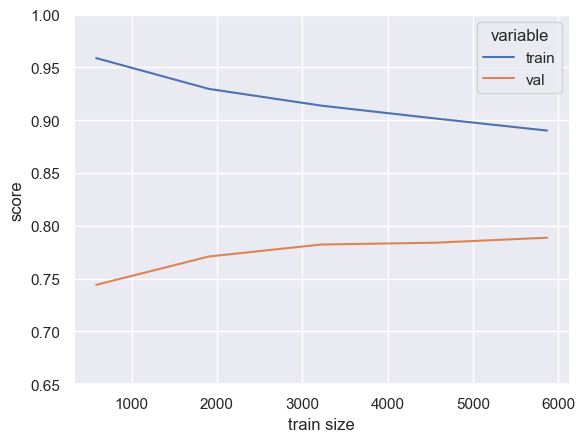

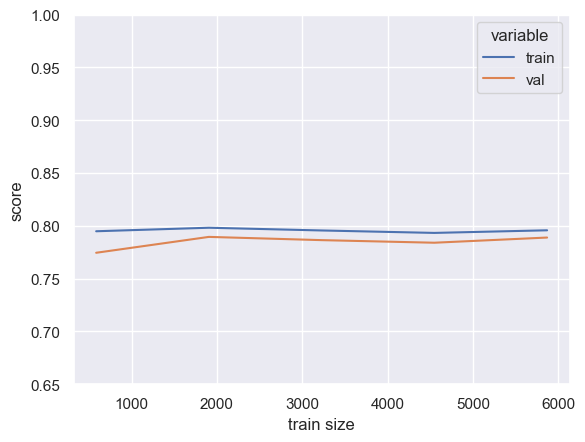

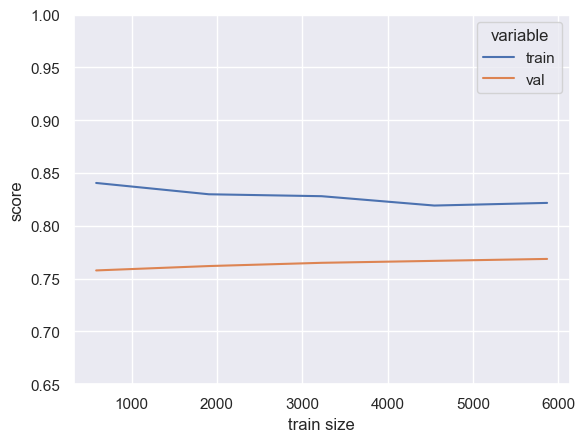

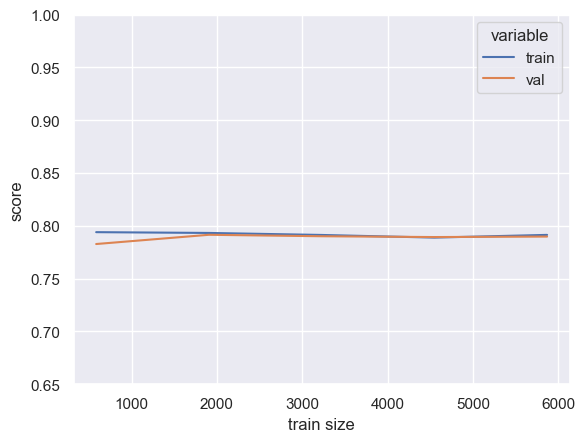

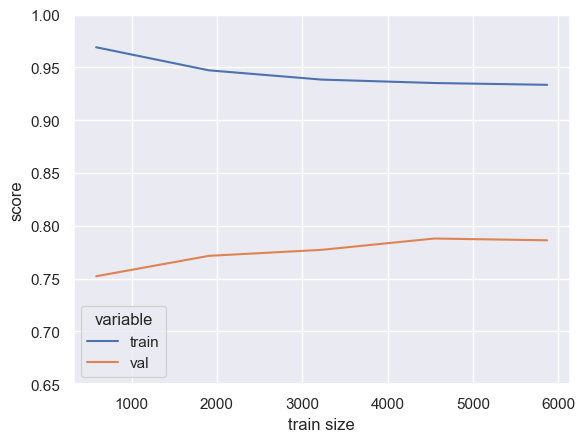

In [60]:
# Test pipeline
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
filepath = 'data/train.csv'
df = pd.read_csv(filepath)

xgb = XGBClassifier()
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegressionCV()
rf = RandomForestClassifier()
model = {
    'xgb':xgb,
    'svc':svc,
    'knn':knn,
    'lr':lr,
    'rf':rf
}
encoding = ['one-hot', 'one-hot', 'one-hot', 'one-hot', 'one-hot']
drop_cols = ['Cabin', 'Name', 'PassengerId']
target_col = 'Transported'
validation = 'cross_validation'
dir_path = {'log':'training log', 'model':'model', 'submission':'submission'}
filling_method = ['numeric:median', 'category:most_frequent']
validation_method = 'cross_validation'
scoring = 'accuracy'
cv = 5
pipline = Pipeline(
    df=df,
    drop_cols=drop_cols,
    model=model,
    encoding=encoding,
    target_col=target_col,
    standarization=True,
    filling_method=filling_method,
    validation_method=validation_method,
    scoring=scoring,
    cv=cv,
    dir_path=dir_path)

pipline.run(log=True, log_dir_name='First test', log_description='Test all modules.')
# pipeline.run()

n-featrues:  1
feature names:  ('CryoSleep',)
cv scores: [0.71088957 0.71088957 0.71472393 0.7154908  0.72908672]
avg score:  0.7162161175955439
--------------------
n-featrues:  2
feature names:  ('CryoSleep', 'Age')
cv scores: [0.72546012 0.72162577 0.72546012 0.73006135 0.74059862]
avg score:  0.7286411961071432
--------------------
n-featrues:  3
feature names:  ('CryoSleep', 'Age', 'FoodCourt')
cv scores: [0.71855828 0.72852761 0.73542945 0.73542945 0.73829624]
avg score:  0.7312482049447006
--------------------
n-featrues:  4
feature names:  ('CryoSleep', 'Age', 'FoodCourt', 'Spa')
cv scores: [0.73082822 0.75613497 0.73389571 0.74923313 0.74827322]
avg score:  0.7436730480392111
--------------------
n-featrues:  5
feature names:  ('CryoSleep', 'Age', 'FoodCourt', 'Spa', 'VRDeck')
cv scores: [0.74616564 0.76763804 0.75996933 0.7607362  0.76362241]
avg score:  0.7596263224554944
--------------------
n-featrues:  6
feature names:  ('CryoSleep', 'Age', 'FoodCourt', 'ShoppingMall', 'S

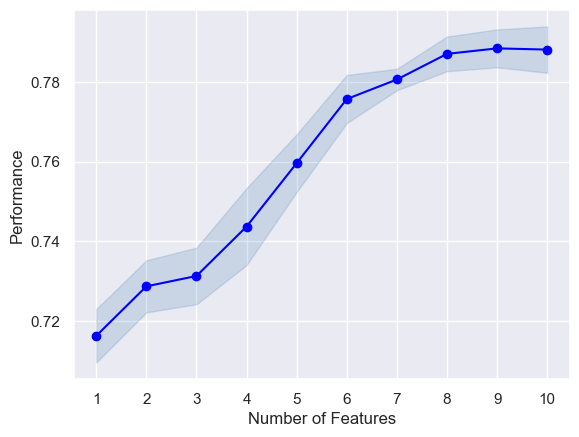

In [61]:
# Test feature selection 
filepath = 'data/train.csv'
df = pd.read_csv(filepath)

dataProcessor = DataProcessor()
featureSelector = FeatureSelector()

xgb = XGBClassifier()
model = {
    'xgb':xgb,
}
encoding = 'target'
drop_cols = ['Cabin', 'Name', 'PassengerId']
target_col = 'Transported'
validation = 'cross_validation'
dir_path = {'log':'training log', 'model':'model', 'submission':'submission'}
filling_method = ['numeric:median', 'category:most_frequent']
validation_method = 'cross_validation'
scoring = 'accuracy'
random_state = 42
cv = 5
img_path = os.path.join('feature-select', 'Sequential Forward Selection 2.png')

train_X, test_X, train_Y, test_Y = dataProcessor.processing(
    df,
    target_col = target_col,
    standarization = True,
    filling_method = filling_method,
    drop_cols = drop_cols,    
    encoding = encoding,
    split_data = True,
    random_state = random_state)

faeture = featureSelector.select(
    train_X,
    train_Y,
    method = 'SFS',
    scoring='accuracy',
    cv=5,
    estimator=xgb,
    verbose=True,
    plot=True,
    imgpath=img_path)

In [62]:
feature = faeture

training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


training...


C:\Users\User\AppData\Local\Temp\ipykernel_2536\1669262358.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


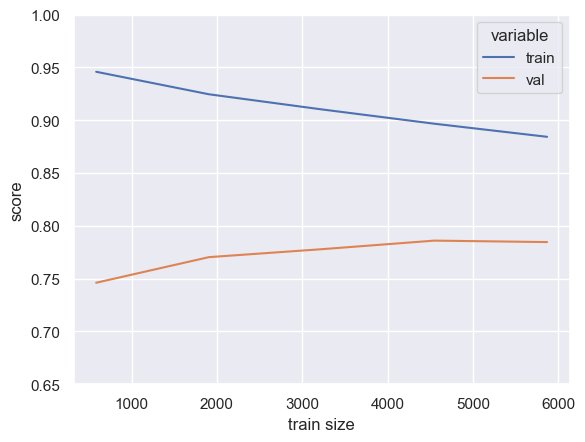

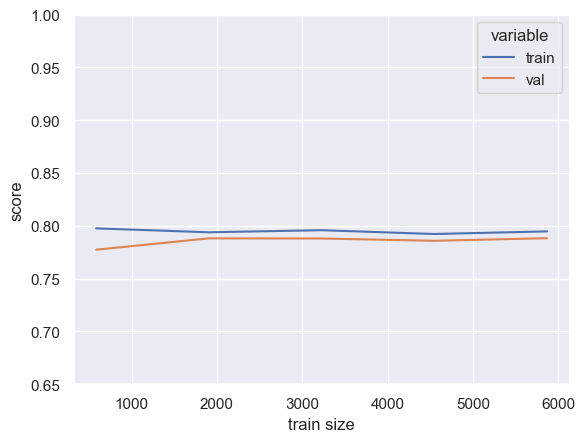

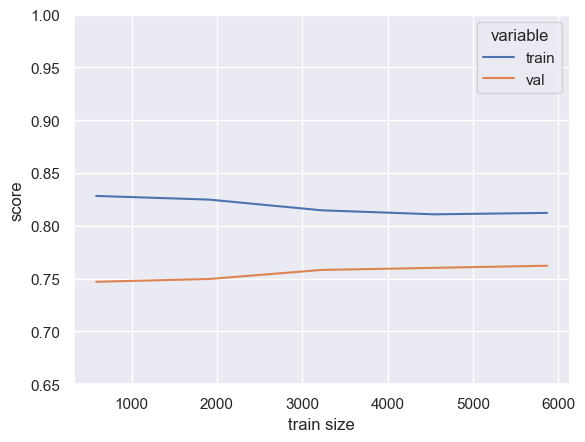

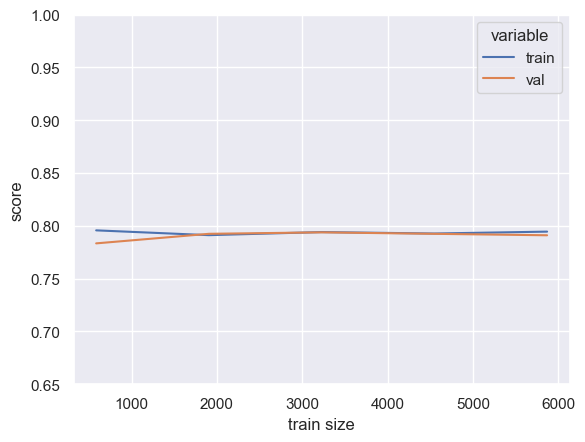

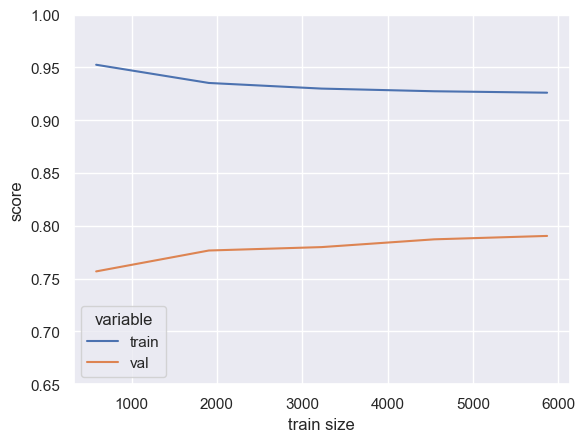

In [64]:
# Test after feature selection 
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
filepath = 'data/train.csv'
df = pd.read_csv(filepath)

xgb = XGBClassifier()
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegressionCV()
rf = RandomForestClassifier()
model = {
    'xgb':xgb,
    'svc':svc,
    'knn':knn,
    'lr':lr,
    'rf':rf
}
encoding = ['target', 'target', 'target', 'target', 'target']
drop_cols = ['Cabin', 'Name', 'PassengerId']
for col in df.columns:
    if col == target_col: continue
    if col not in feature:
        drop_cols.append(col)
target_col = 'Transported'
validation = 'cross_validation'
dir_path = {'log':'training log', 'model':'model', 'submission':'submission'}
filling_method = ['numeric:median', 'category:most_frequent']
validation_method = 'cross_validation'
scoring = 'accuracy'
cv = 5
log_text = "Compare the acc after feature selection and see test score"
pipline = Pipeline(
    df=df,
    drop_cols=drop_cols,
    model=model,
    encoding=encoding,
    target_col=target_col,
    standarization=True,
    filling_method=filling_method,
    validation_method=validation_method,
    scoring=scoring,
    cv=cv,
    dir_path=dir_path)

pipline.run(log=True, log_dir_name='After feature selection', log_description=log_text)

In [65]:
pipline.train_score

,acc,precision,recall,F1,confusion matrix
xgb,0.880043,0.858945,0.911747,0.884559,"[[2741, 492], [290, 2996]]"
svc,0.795367,0.776801,0.833536,0.804169,"[[2446, 787], [547, 2739]]"
knn,0.809787,0.816718,0.802800,0.809699,"[[2641, 592], [648, 2638]]"
lr,0.794140,0.776451,0.830797,0.802705,"[[2447, 786], [556, 2730]]"
rf,0.925449,0.882932,0.982349,0.929991,"[[2805, 428], [58, 3228]]"


In [2]:
pipline.test_score

NameError: name 'pipline' is not defined

In [9]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
filepath = 'data/train.csv'
df = pd.read_csv(filepath)

xgb = XGBClassifier()
rf = RandomForestClassifier()
model = {
    'xgb':xgb,
    'rf':rf
}
encoding = ['target', 'target']
drop_cols = ['Cabin', 'Name', 'PassengerId']
target_col = 'Transported'
feature = ('HomePlanet', 'CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')
for col in df.columns:
    if col == target_col: continue
    if col not in feature:
        drop_cols.append(col)


validation = 'cross_validation'
dir_path = {'log':'training log', 'model':'model', 'submission':'submission'}
filling_method = ['numeric:median', 'category:most_frequent']
validation_method = 'cross_validation'
scoring = 'accuracy'
cv = 5
log_text = "Compare the acc after feature selection and see test score"
pipline = Pipeline(
    df=df,
    drop_cols=drop_cols,
    model=model,
    encoding=encoding,
    target_col=target_col,
    standarization=True,
    filling_method=filling_method,
    validation_method=validation_method,
    scoring=scoring,
    cv=cv,
    dir_path=dir_path)

pipline.run(log=False, log_dir_name='After feature selection', log_description=log_text)

training...
training...


In [ ]:
results = xgb.evals_result()

# fig, ax = plt.subplots()
# ax.plot(x_axis, results['validation_0']['logloss'], label)